In [ ]:
import pandas as pd
import numpy as np
import math
import gc
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D

from faker.providers.job.en_US import Provider as jobp
from faker.providers.address.en_US import Provider as addressp
from faker.providers.color.en_US import Provider as colorp
from faker.providers.currency.en_US import Provider as currencyp

import numpy as np
import random

random.seed(64)

def generate_probabilities_normal(n,mu,sigma):

    arr = np.zeros(n)

    for i in range(len(arr)):
        x = i - mu
        arr[i] = math.exp(-(x**2)/(2*sigma**2)) / (sigma*math.sqrt(2*math.pi))

    arr = arr / arr.sum()

    return(arr)

def generate_probabilities_exp(n,lamda):

    arr = np.zeros(n)

    for i in range(len(arr)):
        arr[i] = lamda * math.exp(-lamda * i)

    arr = arr / arr.sum()

    return(arr)


def binary_encoding(word_list):

    num_bits = math.ceil(math.log2(len(word_list)))


    binary_dict = {}
    for i, word in enumerate(word_list):
        binary_dict[word] = format(i, f"0{num_bits}b")


    binary_array = np.array([int(binary_dict[word], 2) for word in word_list])
    binary_list = binary_array.tolist()

    return binary_list


[0.4, 0.34, 0.16, 0.1]


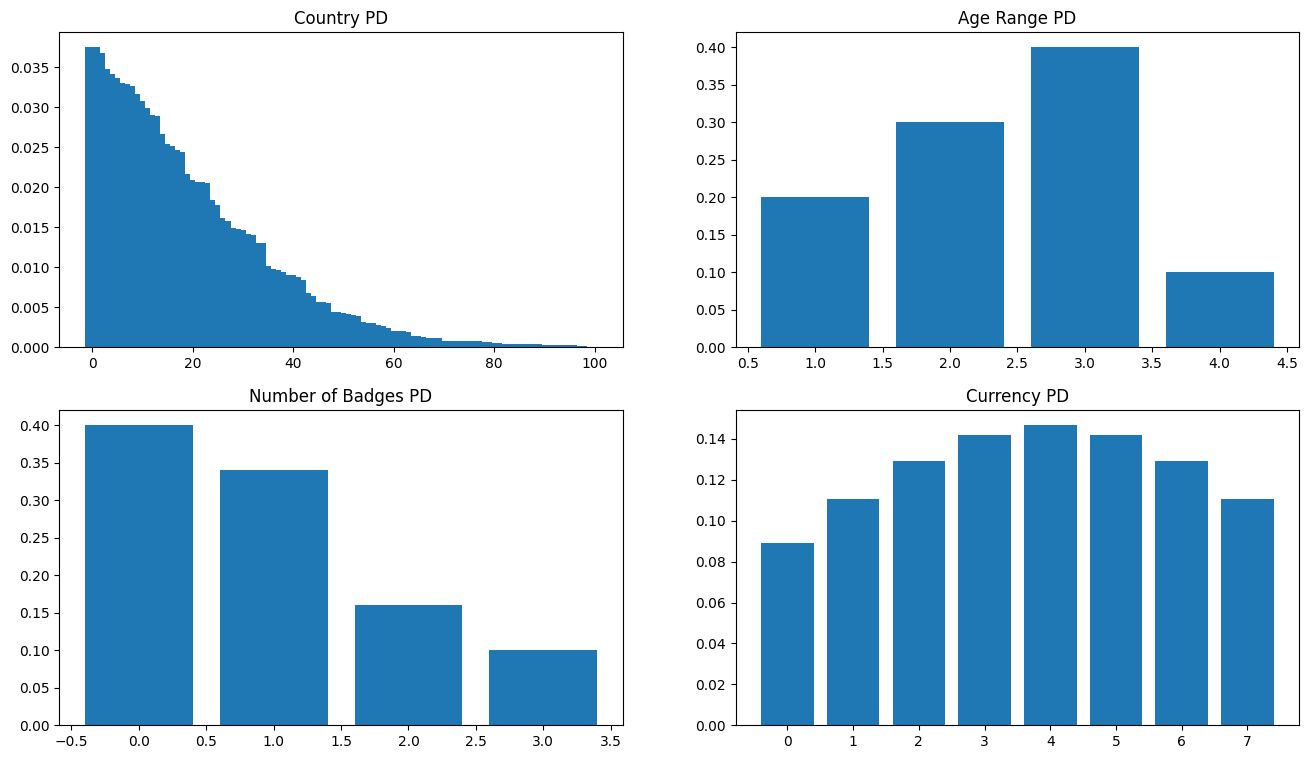

In [2]:
countries = pd.read_excel('Population.xlsx').sort_values(by='Population').head(100)
total = int(countries['Population'].sum())
countries['Prob'] = countries['Population']/total
countries = countries.sort_values(by=['Prob'],ascending=False)
countries = countries.reset_index()
p_country = countries['Prob']

badges = pd.read_excel('occupation.xlsx',sheet_name='Table 1.1',header=1)
badges = badges.rename(columns={'2021 National Employment Matrix title': 'badges', 'Employment, 2021' : 'employees'})
badges = badges.drop(index=0)[['badges','employees']].dropna().head(4)

gender = ['M','F']
bday = [i for i in range(365)]
age_range = [1,2,3,4]

total = badges['employees'].sum()
badges['prob'] = badges['employees']/total
badges = badges.sort_values(by=['prob'],ascending=False)
badges = badges.reset_index()
p_badges = badges['prob']
p_badges = [0.4,0.34,0.16,0.1]

print(p_badges)

badges = np.array(binary_encoding(badges.index))
country = np.array(binary_encoding(countries.index))
age_range = np.array(binary_encoding(age_range))

age_range = list(np.arange(1,5))
currency = list(np.arange(8))

p_age_range = [0.2,0.3,0.4,0.1]
p_currency = generate_probabilities_normal(len(currency),len(currency)/2,len(currency)/2)
p_gender = [0.20,0.8]
p_bday = [1/365]*365



fig,axs = plt.subplots(2,2,figsize=(16,9))


axs[0][0].bar(country,p_country,width=3)
axs[0][0].set_title('Country PD')

axs[0][1].bar(age_range,p_age_range)
axs[0][1].set_title('Age Range PD')



axs[1][0].bar(badges,p_badges)
axs[1][0].set_title('Number of Badges PD')

axs[1][1].bar(currency,p_currency)
axs[1][1].set_title('Currency PD')


fig.savefig('attributes_app2.eps', bbox_inches='tight',dpi=300)

df_app2 = pd.DataFrame(columns=['country','bday','badges','gender','currency','age'])

N = 10_000_000

df_app2 = pd.DataFrame({
	'country': np.random.choice(country, N, p=p_country),
	'bday': np.random.choice(bday, N),
    'badges': np.random.choice(badges, N, p=p_badges),
    'gender': np.random.choice(gender, N),
    'currency': np.random.choice(currency, N, p=p_currency),
    'age_range': np.random.choice(age_range, N, p=p_age_range),
    },dtype='category')

In [3]:
countries

,index,Country,Population,Prob
0,145,Norway,5232929,0.037509
1,45,Republic of the Congo,5125821,0.036742
2,46,Costa Rica,4857274,0.034817
3,91,Ireland,4773095,0.034213
4,140,New Zealand,4692700,0.033637
...,...,...,...,...
95,180,Saint Pierre and Miquelon,31949,0.000229
96,27,British Virgin Islands,30661,0.000220
97,148,Palau,21503,0.000154
98,136,Nauru,13049,0.000094


In [4]:
df_app2

,country,bday,badges,gender,currency,age_range
0,12,61,2,F,4,1
1,11,243,0,F,3,2
2,28,363,1,M,4,2
3,5,137,1,M,5,2
4,29,194,1,F,7,2
...,...,...,...,...,...,...
9999995,15,83,1,F,3,3
9999996,5,307,0,M,1,2
9999997,12,166,3,F,0,2
9999998,50,345,0,M,2,3


In [5]:
import pandas as pd
import polars as pl
df_polars = pl.DataFrame(df_app2)
attr = ['country','age_range','badges','currency','bday']
tbp1 = pd.DataFrame()
for i in range(len(attr)):
    combinations_count = df_polars.group_by(attr[0:i+1]).agg(pl.len().alias('count')).sort('count')
    combinations_count = combinations_count.to_pandas()
    combinations_count['cumsum'] = combinations_count['count'].cumsum()
    suma = combinations_count['count'].sum()
    combinations_count['cdf'] = combinations_count['cumsum'] /suma
    combinations_count

    samples = pd.Series(np.repeat(combinations_count['count'].values, combinations_count['count'].values))
    tbp1[str(i+1)] = samples.reset_index(drop=True)

In [6]:
tbp1 = tbp1.rename(columns={"1": "A", "2": "A+B", "3": "A+B+C", "4": "A+B+C+D", "5": "A+B+C+D+E"})

Text(0.5, 1.0, '$K^N_{P}$ for N={1,2,3,4,5} and P={10,25,50,75,90,100}')

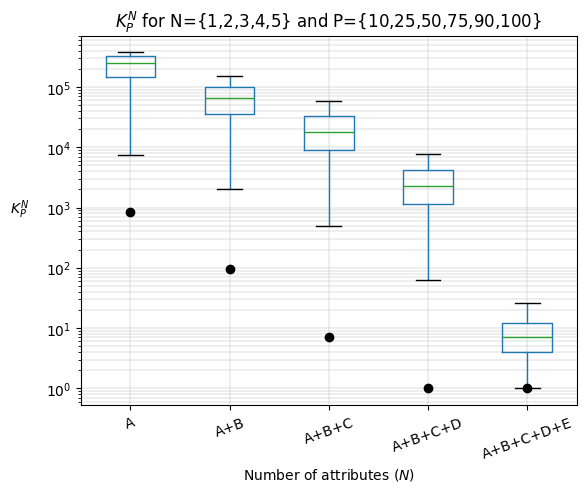

In [7]:
bp = pd.DataFrame(tbp1).boxplot(whis=[1, 99], showfliers=False)
min_val = tbp1['A'].min()
plt.scatter(1, min_val, color='black', label='Mínimo absoluto', zorder=3)
min_val = tbp1['A+B'].min()
plt.scatter(2, min_val, color='black', label='Mínimo absoluto', zorder=3)
min_val = tbp1['A+B+C'].min()
plt.scatter(3, min_val, color='black', label='Mínimo absoluto', zorder=3)
min_val = tbp1['A+B+C+D'].min()
plt.scatter(4, min_val, color='black', label='Mínimo absoluto', zorder=3)
min_val = tbp1['A+B+C+D+E'].min()
plt.scatter(5, min_val, color='black', label='Mínimo absoluto', zorder=3)

plt.semilogy()
plt.grid(True, which="both", linewidth=0.3)

plt.xticks(rotation=20)

plt.ylabel('$K^N_{P}$',rotation=0,labelpad=12,ha='right')
plt.xlabel('Number of attributes ($N$)')
plt.title('$K^N_{P}$ for N={1,2,3,4,5} and P={10,25,50,75,90,100}')

In [8]:
tbp1['A+B+C+D'].quantile(0.01)

np.float64(63.0)